In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to access public datasets from the knoema.com
import knoema

import bamboolib

# 0. Theoretical background

$$r_t^{eqy} = E[r_t^{eqy}] + \beta_1^{eqy} INFL_t+\beta_2^{eqy} GR_t+ \beta_3^{eqy} FS_t + \alpha_t^{eqy}$$
$$r_t^{ust} = E[r_t^{ust}] + \beta_1^{ust} INFL_t+\beta_2^{ust} GR_t+ \beta_3^{ust} FS_t + \alpha_t^{ust}$$
$$\vdots$$
$$r_t^{fxcs} = E[r_t^{fxcs}] + \beta_1^{fxcs} INFL_t+\beta_2^{fxcs} GR_t+ \beta_3^{fxcs} FS_t + \alpha_t^{fxcs}$$

, where
- $INFL_t$ stands for an *inflation* macro-factor return at time t. Likewise, $GR$ for *growth* and $FS$ for *finantial stress* factors.
- $r_t^{eqy}$ is an *excess* return of global equity markets at time t as one of the base assets. T-Bill 1M is used for the excess return calculation. A risk free return such as $r_f$ is omiited for simplicity.
  - $ust$ stands for U.S 10Yr Treasury, and the rest of notation should be the same as that of $eqy$. The same naming rule applies for the rest of base assets in denoting $r_t^{asset}$.
  - A full list of base assets used in this model : Equities($eqy$), Treasuries($ust$), Credit($cre$), Inflation-Linked Bonds($ilb$), Gold(gold), Industrial Metals($inm$), Energy commodity($eng$), U.S. Dollar($dxy$), Commodity vs safe haven currencies ($fxcs$). Abbreviations in ().
- $E[\cdot]$ is an expected excess return.
- $\beta_{\#}^{instrument}$ is a factor beta, or factor loading, for that $instrument$. This value is the **same across all periods** of time being modeled. Therefore, there is no subscript $t$. Instead, we have a digit subscript 1 for $INFL$ beta, 2 for $GR$ beta and 3 for $FS$ beta.
  - e.g. $\beta_1^{eqy}$ is a sensitivy of Equities to $INFL$ factor.
- $E[\alpha^{asset}] = 0$ for all periods of time being modeled.

# 1. Load datasets

#### Set data frequency

In [2]:
_freq = 'M'

#### From Bloomberg (bbg)
- For data of more recent years.

In [3]:
bbg_filename = '../../data/raw/base_assets_price_bbg_M.log'

df_bbg = pd.read_csv(bbg_filename, header=2, parse_dates=['date'])
df_bbg = df_bbg.set_index(['date'], drop=True)

In [4]:
df_bbg.tail()

,DMEQ_idx,GLT_idx,CRE_Baa_idx,CRE_Aaa_idx,TIPS_idx,GOLD_pr,INM_idx,ENGY_idx,DXY_idx,USDCAD_rate,USDNOK_rate,AUDUSD_rate,USDJPY_rate,USDCHF_rate,TBILL3M_idx,EMEQ_idx,ACEQ_idx
date,,,,,,,,,,,,,,,,,
2019-11-29,2292.26,2383.16,4206.804,2246.016,316.2039,1463.98,314.60,190.0800,98.273,1.3282,9.2248,0.6763,109.49,1.0002,1.5672,1040.05,546.70
2019-12-31,2358.47,2369.78,4233.494,2244.171,317.4027,1517.27,324.21,206.6327,96.389,1.2990,8.7855,0.7021,108.61,0.9666,1.5436,1114.66,565.24
2020-01-31,2342.41,2427.69,4332.237,2281.815,324.0671,1589.16,301.55,174.8693,97.390,1.3237,9.2011,0.6692,108.35,0.9634,1.5382,1062.34,558.62
2020-02-28,2141.12,2492.04,4372.826,2320.946,328.5524,1585.69,298.11,154.7120,98.132,1.3407,9.3939,0.6515,107.89,0.9649,1.2670,1005.52,512.76
2020-03-31,1852.73,2564.12,3920.704,2333.130,322.7761,1577.18,267.86,82.0629,99.048,1.4062,10.4028,0.6131,107.54,0.9611,0.0610,848.58,442.35


#### From Global Financial Data (gfd)
- For data of older years; since 1850.

In [5]:
gfd_filename = '../../data/raw/base_assets_price_gfd_M.log'

df_gfd = pd.read_csv(gfd_filename, header=0, parse_dates=['Date'])
df_gfd = df_gfd.rename(columns={'CHFUSD': 'CHFUSD_rate', 'GBPUSD':'GBPUSD_rate'})

In [6]:
df_gfd.tail()

,Date,Ticker,Close
38794,2019-12-31,USDSEK,9.3620
38795,2020-01-31,USDSEK,9.6261
38796,2020-02-29,USDSEK,9.5959
38797,2020-03-31,USDSEK,9.9096
38798,2020-04-30,USDSEK,9.9367


We pivot this table.

In [7]:
df_gfd = pd.pivot_table(df_gfd, index=['Date'], columns=['Ticker'])

# Drop one of the top multi-index column, namely, "Close"
df_gfd.columns = df_gfd.columns.droplevel(0)

Add a prefix `_rate` to an FX rate column name.

In [8]:
df_gfd.columns = [col + "_rate" if col.find("USD") >= 0 else col for col in df_gfd.columns]

#### From survey data (sv)
- For the U.S. forecasted inflation by professionals:
  - U.S. Survey of Professional Forecasters, `df_spf`: https://www.philadelphiafed.org/-/media/research-and-data/real-time-center/survey-of-professional-forecasters/historical-data/inflation.xlsx?la=en
  - Livingston Survey, `df_lv`: https://www.philadelphiafed.org/-/media/research-and-data/real-time-center/survey-of-professional-forecasters/historical-data/additional-cpie10.xlsx?la=en
  - See: page #37 at https://www.philadelphiafed.org/-/media/research-and-data/real-time-center/survey-of-professional-forecasters/spf-documentation.pdf?la=en

In [9]:
spf_filename = '../../data/raw/survey_of_professionals.log'

df_spf = pd.read_csv(spf_filename, header=0)
df_spf['date'] = pd.to_datetime({
                    'year': df_spf.YEAR,
                    'month': df_spf.QUARTER * 3,
                    'day': 1
                })
df_spf = df_spf.set_index(keys='date')

In [10]:
df_lv_filename = '../../data/raw/survey_of_livingston.log'

df_lv = pd.read_csv(df_lv_filename, header=13)

# 2. Preprocessing

## 1) Merge two datasets, `df_gfd` and `df_bbg`
- Changing `date` formats to properly join

In [11]:
df_gfd.index

DatetimeIndex(['1850-01-31', '1850-02-28', '1850-03-31', '1850-04-30',
               '1850-05-31', '1850-06-30', '1850-07-31', '1850-08-31',
               '1850-09-30', '1850-10-31',
               ...
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29',
               '2020-03-31', '2020-04-30'],
              dtype='datetime64[ns]', name='Date', length=2044, freq=None)

In [12]:
df_bbg.index

DatetimeIndex(['1959-12-31', '1960-01-29', '1960-02-29', '1960-03-31',
               '1960-04-29', '1960-05-31', '1960-06-30', '1960-07-29',
               '1960-08-31', '1960-09-30',
               ...
               '2019-06-28', '2019-07-31', '2019-08-30', '2019-09-30',
               '2019-10-31', '2019-11-29', '2019-12-31', '2020-01-31',
               '2020-02-28', '2020-03-31'],
              dtype='datetime64[ns]', name='date', length=724, freq=None)

#### Change each index type to `PeriodIndex` with **M** frequency

In [13]:
gfd_index = pd.to_datetime(df_gfd.index).to_period(_freq)
bbg_index = pd.to_datetime(df_bbg.index).to_period(_freq)

In [14]:
df_gfd = df_gfd.set_index(gfd_index)
df_bbg = df_bbg.set_index(bbg_index)

#### Joining `df_gfd` and `df_bbg` to create `df`

In [15]:
df = pd.merge(df_gfd, df_bbg, how='left', left_index=True, right_index=True, suffixes=('_gfd', '_bbg'))

Data range is:

In [16]:
df.index.min(), df.index.max()

(Period('1850-01', 'M'), Period('2020-04', 'M'))

In [17]:
df.index

PeriodIndex(['1850-01', '1850-02', '1850-03', '1850-04', '1850-05', '1850-06',
             '1850-07', '1850-08', '1850-09', '1850-10',
             ...
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
             '2020-01', '2020-02', '2020-03', '2020-04'],
            dtype='period[M]', name='Date', length=2044, freq='M')

To rename the index name, we set *inplace=True* in order for the data frame to retain all its properties.
- https://stackoverflow.com/questions/19851005/rename-pandas-dataframe-index

In [18]:
df.index.rename('date', inplace=True)

In [19]:
df

,CMWXMMM,CPUSAM,GBPUSD_rate,IDUSAD,ITUSA3CMD,NG_P_WTD,TRUSACOM,TRUSG10M,USDBEF_rate,USDCAD_rate_gfd,...,ENGY_idx,DXY_idx,USDCAD_rate_bbg,USDNOK_rate_bbg,AUDUSD_rate,USDJPY_rate_bbg,USDCHF_rate_bbg,TBILL3M_idx,EMEQ_idx,ACEQ_idx
date,,,,,,,,,,,,,,,,,,,,,
1850-01,NaN,NaN,23.047528,NaN,NaN,NaN,1.051075,3.306525,5.2607,0.2581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-02,NaN,NaN,23.428364,NaN,NaN,NaN,1.055901,3.315689,5.2468,0.2568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-03,NaN,NaN,23.360561,NaN,NaN,NaN,1.052282,3.273533,5.2524,0.2568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-04,NaN,NaN,23.091783,NaN,NaN,NaN,1.057999,3.475150,5.2775,0.2555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-05,NaN,NaN,23.911980,NaN,NaN,NaN,1.081762,3.482482,5.2330,0.2528,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12,77.469997,256.974,1.759655,NaN,1.55,NaN,23920.300000,10836.125049,0.8917,1.2986,...,206.6327,96.389,1.2990,8.7855,0.7021,108.61,0.9666,1.5436,1114.66,565.24
2020-01,77.702232,257.971,1.742672,NaN,1.55,NaN,24418.540000,11252.031439,0.9013,1.3235,...,174.8693,97.390,1.3237,9.2011,0.6692,108.35,0.9634,1.5382,1062.34,558.62
2020-02,73.015869,258.678,1.643800,NaN,1.27,NaN,24727.670000,11666.405078,0.9069,1.3396,...,154.7120,98.132,1.3407,9.3939,0.6515,107.89,0.9649,1.2670,1005.52,512.76


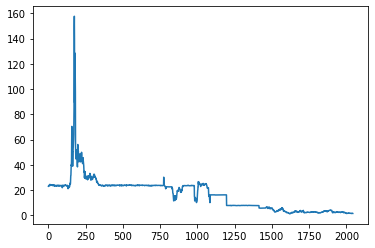

In [20]:
plt.plot(df.GBPUSD_rate.values)

In [21]:
df2 = df.sort_index()

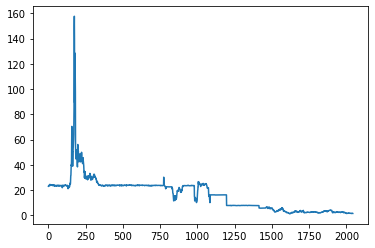

In [22]:
plt.plot(df2.GBPUSD_rate.values)

In [23]:
np.all(df2.GBPUSD_rate.values == df.GBPUSD_rate.values)

True

## 2) Cleaning `df_lv`

####  Create `date` column

In [24]:
# Split. e.g: 2019:3 in `Survey Date` to two different columns
# bamboolib live code export
split_df = df_lv["Survey Date"].str.split(':', expand=True)
split_df.columns = [f"Survey Date_{id_}" for id_ in range(len(split_df.columns))]
df_lv = pd.merge(df_lv, split_df, how="left", left_index=True, right_index=True)

# Create `date` index
df_lv['date'] = pd.to_datetime({
    'year': df_lv['Survey Date_0'],
    'month': df_lv['Survey Date_1'].astype(int, errors='raise')*3,
    'day': 1
})
df_lv = df_lv.set_index('date')
df_lv = df_lv.drop(['Survey Date', 'Survey Date_0', 'Survey Date_1', 'Blue Chip', 'Livingston'], axis=1)
df_lv = df_lv.dropna()

#### Some data points in `df_lv` are too big in their absolue values that make no sense.
- Its scale is 1e9
- Change it to NaN

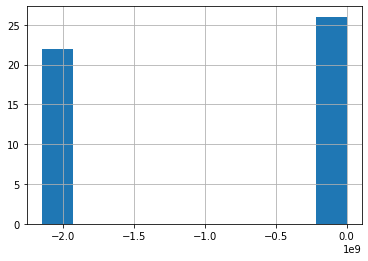

In [25]:
df_lv.Combined.hist()

In [26]:
df_lv.Combined = df_lv.Combined.mask((df_lv.Combined > 1e3) | (df_lv.Combined < -1e3))

Now it looks fine.

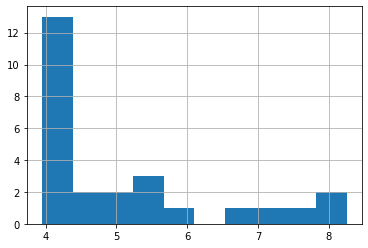

In [27]:
df_lv.Combined.hist()

In [28]:
df_lv.tail()

,Combined
date,
1990-09-01,NaN
1990-12-01,4.15
1991-03-01,4.05
1991-06-01,4.08
1991-09-01,NaN


#### Merge `df_spf` and `df_lv` to create one survey table `df_sv`

In [29]:
df_sv = pd.merge(left=df_lv, right=df_spf, how='outer', on='date')

In [30]:
df_sv.columns

Index(['Combined', 'YEAR', 'QUARTER', 'INFPGDP1YR', 'INFCPI1YR', 'INFCPI10YR'], dtype='object')

We drop unnecessary columns and change a column name.
- `INFPGDP1YR`, not CPI forecasts. Drop it.
- Rename: `Combined` -> `LVCPI10YR`, `INFCPI1YR` -> `CPI1YR_F`
  - Now `LVCPI10YR` is the forecast of the average rate of CPI inflation for the next 10 years by Livingston survey. 

**Livingston Survey**: Long-term inflation forecasts are taken in every survey, June and December. 

**Blue Chip Economic Indicators**: Long-term inflation forecasts are taken twice a year (March and October).  The original data were obtained from Robert Eggert, Editor, Blue Chip Economic Indicators, P.O. Box 2243, Sedona, Arizona 86339, phone (602) 282-4882.  Note that prior to 1983, and in 1983:4, the variable was the GNP deflator rather than the CPI.


In [31]:
df_sv = df_sv.drop(['YEAR', 'QUARTER', 'INFPGDP1YR'], axis=1)
df_sv = df_sv.rename(columns={
    'Combined': 'LVCPI10YR',
    'INFCPI1YR': 'CPI1YR_F'
})

#### For some reason, 1970s data is stored in somewhere in the middle, not sorted.
- So we sort `df_sv` by its index.

In [32]:
df_sv = df_sv.sort_index()

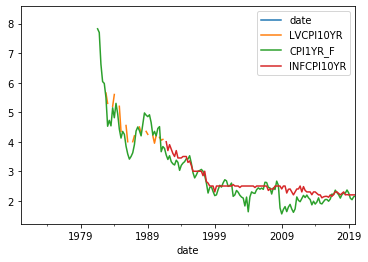

In [33]:
df_sv.loc[:, ['date', 'LVCPI10YR', 'CPI1YR_F', 'INFCPI10YR']].plot()

An observation: `LVCPI10YR` and `INFCPI10YR` have no overlap in their data.

In [34]:
df_sv.LVCPI10YR.dropna().tail(1), df_sv.INFCPI10YR.dropna().head(1)

(date
 1991-06-01    4.08
 Name: LVCPI10YR, dtype: float64,
 date
 1991-12-01    4.0
 Name: INFCPI10YR, dtype: float64)

So we can simply merge them using *fillna()*

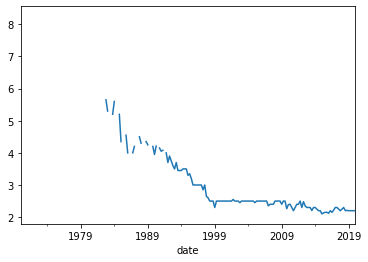

In [35]:
df_sv['CPI10YR_F'] = df_sv.INFCPI10YR.fillna(df_sv.LVCPI10YR)
df_sv['CPI10YR_F'].plot()

#### We backfill `CPI10YR_F` from the first valid data point.
- We don't backfill what comes before the first valid data point.

In [36]:
df_sv.CPI10YR_F.dropna()

date
1979-12-01    6.90
1980-06-01    7.85
1980-12-01    8.25
1981-06-01    7.80
1981-12-01    7.05
              ... 
2019-03-01    2.20
2019-06-01    2.20
2019-09-01    2.20
2019-12-01    2.20
2020-03-01    2.20
Name: CPI10YR_F, Length: 140, dtype: float64

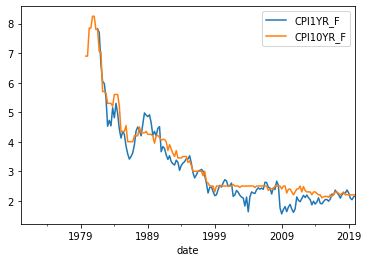

In [37]:
cpi10yr_f = df_sv.loc[df_sv.CPI10YR_F.first_valid_index():,'CPI10YR_F'].fillna(method='ffill')
df_sv = pd.merge(left=df_sv, right=cpi10yr_f, how='outer', on='date', suffixes=('_unfilled', ''))
df_sv = df_sv.drop(['LVCPI10YR', 'INFCPI10YR', 'CPI10YR_F_unfilled'], axis=1)
df_sv.loc[:, ['CPI1YR_F','CPI10YR_F']].plot()

In [38]:
sv_index = pd.to_datetime(df_sv.index).to_period(_freq)
df_sv.set_index(sv_index, inplace=True)

#### Drop rows where their keys are this month if `_freq` == 'M'.
- They are not really the end-of-month data, but within-month data. This happens because, e.g., data downloaded on 2020-04-18 comes with a tag as 2020-04-01, which will be in turn converted into April 2020 which looks like an end-of-month data point.

In [39]:
if _freq == 'M':
    this_month = pd.Timestamp.today().to_period(_freq)
    df = df.loc[~(df.index==this_month), :]

## 3) Merge `df_sv` with `df`

In [40]:
df = df.merge(df_sv, how='outer', left_index=True, right_index=True)

In [41]:
df.head()

,CMWXMMM,CPUSAM,GBPUSD_rate,IDUSAD,ITUSA3CMD,NG_P_WTD,TRUSACOM,TRUSG10M,USDBEF_rate,USDCAD_rate_gfd,...,USDCAD_rate_bbg,USDNOK_rate_bbg,AUDUSD_rate,USDJPY_rate_bbg,USDCHF_rate_bbg,TBILL3M_idx,EMEQ_idx,ACEQ_idx,CPI1YR_F,CPI10YR_F
date,,,,,,,,,,,,,,,,,,,,,
1850-01,NaN,NaN,23.047528,NaN,NaN,NaN,1.051075,3.306525,5.2607,0.2581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-02,NaN,NaN,23.428364,NaN,NaN,NaN,1.055901,3.315689,5.2468,0.2568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-03,NaN,NaN,23.360561,NaN,NaN,NaN,1.052282,3.273533,5.2524,0.2568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-04,NaN,NaN,23.091783,NaN,NaN,NaN,1.057999,3.475150,5.2775,0.2555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850-05,NaN,NaN,23.911980,NaN,NaN,NaN,1.081762,3.482482,5.2330,0.2528,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Generate base asset indices

#### `bf` is a DataFrame of base asset indices where its columns are baset asset indices.

In [42]:
bf = pd.DataFrame(index = df.index)

#### Index names in `gray boxes`

### 1) Equities

`DMEQ` (Equities): Log returns of an equity index.
  - Since January 1970, **DMEQ_idx**: MSCI World in USD.
  - Before that date, **_SPXD**: S&P (500)

This is less preferred
```python
np.log(df['close']).diff()```
because this breaks when df['close'] is negative.

#### Take log returns

In [43]:
df['DMEQ_recent'] = np.log(df.DMEQ_idx/df.DMEQ_idx.shift(1))
df['DMEQ_older'] = np.log(df._SPXD/df._SPXD.shift(1))

#### Merge two columns to create `DMEQ`

In [44]:
bf['DMEQ'] = df.DMEQ_recent.fillna(df.DMEQ_older)

### 2) Treasuries

`GLT` (Treasuries): Log returns of a long-term government bond index.
  - Since February 1973, **GLT_idx**: Bloomberg Barclays U.S. Treasury Total Return Unhedged USD
  - Before that date, **TRUSG10M**: GFD Indices USA 10-year Government Bond Total Return Index.

In [45]:
df['GLT_recent'] = np.log(df.GLT_idx/df.GLT_idx.shift(1))
df['GLT_older'] = np.log(df.TRUSG10M/df.TRUSG10M.shift(1))
bf['GLT'] = df.GLT_recent.fillna(df.GLT_older)

### 3) Credit

`CRE` (Credit): Log returns of Baa-rating index - log returns of Aaa-rating index.
  - **CRE_Baa_idx**: Bloomberg Barclays U.S. Credit Baa index vs. **CRE_Aaa_idx**: Bloomberg Barclays U.S. Credit Aaa index since February 1973.
  - **_DJCBPD**: Dow Jones Corporate Bond Price Index (new) vs. **TRUSACOM** GFD Indices USA Total Return AAA Corporate Bond Index before that date.

In [46]:
df['CRE_recent'] = np.log(df.CRE_Baa_idx/df.CRE_Baa_idx.shift(1)) - np.log(df.CRE_Aaa_idx/df.CRE_Aaa_idx.shift(1))
df['CRE_older'] = np.log(df._DJCBPD/df._DJCBPD.shift(1)) - np.log(df.TRUSACOM/df.TRUSACOM.shift(1))
bf['CRE'] = df.CRE_recent.fillna(df.CRE_older)

### 4) Inlfation-Linked Bond

`ILB` (Inflation-Linked Bonds): Conceptually it's, a *break-even inflation rate*. It's defined as log returns of government bond index ("*nominal return*") - log returns inflation-linked index ("*real return*")
  - A break-even inflation rate (**BEI**) = rate of returns of nominal bonds - rate of returns of TIPS on the same maturity (10 years in this case).
  - **BEI** is believed to be a leading indicator of CPI. Since we will get an `ILB` exposure through TIPS, we are assuming: $$\textrm{ILB} \propto \textrm{BEI}.$$
  - Since April 1997, **GLT_idx** Bloomberg Barclays U.S. Treasury Total Return Unhedged USD ("*nominal return*") vs. **TIPS_idx**: Log returns of Bloomberg Barclays U.S. TIPS ("*real return*").
  - From 3Q 1981 to March 1997, averages of U.S. Survey of Professional Forecasters' 1-year forecasted inflation **CPI1YR_F** and 10-year forecasted inflation **CPI10YR_F**. Still, it's a proxy of a break-even inflation rate.
    - 1-year forecated inflation above is defined as an average inflation over the four quarters following the quarter when we conducted the survey.
    - As the 10-year forcasted inflation is only available since 1991 on an annual basis, an alternative source called *Livingston Survey* is used for an older period of 3Q81 to 4Q90.
  - Before that date, log returns of $\frac{1}{3}($CPI$_{t-1}$ + CPI$_t$ + CPI$_{t+1})$ as a proxy of break-even inflation rate, where CPI is **CPUSAM**: United States BLS Consumer Price *Index* Inflation Rate NSA. We assume this monthly log returns of the index can be a proxy of *nominal return - real return*.
    - t-1: one-year ago; t+1: one-year ahead

In [47]:
df.columns

Index(['CMWXMMM', 'CPUSAM', 'GBPUSD_rate', 'IDUSAD', 'ITUSA3CMD', 'NG_P_WTD',
       'TRUSACOM', 'TRUSG10M', 'USDBEF_rate', 'USDCAD_rate_gfd',
       'USDCHF_rate_gfd', 'USDDEM_rate', 'USDFRF_rate', 'USDITL_rate',
       'USDJPY_rate_gfd', 'USDNLG_rate', 'USDNOK_rate_gfd', 'USDSEK_rate',
       '_DJCBPD', '_SPXD', '__WTC_D', '__XAU_D', 'DMEQ_idx', 'GLT_idx',
       'CRE_Baa_idx', 'CRE_Aaa_idx', 'TIPS_idx', 'GOLD_pr', 'INM_idx',
       'ENGY_idx', 'DXY_idx', 'USDCAD_rate_bbg', 'USDNOK_rate_bbg',
       'AUDUSD_rate', 'USDJPY_rate_bbg', 'USDCHF_rate_bbg', 'TBILL3M_idx',
       'EMEQ_idx', 'ACEQ_idx', 'CPI1YR_F', 'CPI10YR_F', 'DMEQ_recent',
       'DMEQ_older', 'GLT_recent', 'GLT_older', 'CRE_recent', 'CRE_older'],
      dtype='object')

In [48]:
np.log(df.CPI1YR_F)

date
1850-01         NaN
1850-02         NaN
1850-03         NaN
1850-04         NaN
1850-05         NaN
             ...   
2019-11         NaN
2019-12    0.760058
2020-01         NaN
2020-02         NaN
2020-03    0.769275
Freq: M, Name: CPI1YR_F, Length: 2043, dtype: float64

In [49]:
df['ILB_recent'] = np.log(df.GLT_idx/df.GLT_idx.shift(1)) - np.log(df.TIPS_idx/df.TIPS_idx.shift(1))

#### Normalize a scale
- The scale of `ILB_recent` is $\ln\frac{P_1}{P_2}$, where $P_i$ is at an index scale. Putting it as $X$,
$$X = \ln\frac{P_1}{P_2}$$
- Differently, the scale of `ILB_older`, calling it $Y$,
$$Y=(\frac{P_1}{P_2}-1)*100$$
- To make $X$ and $Y$ comparable in their scale, a transformation would be done by:
$$\ln\frac{P_1}{P_2} = \ln(\frac{Y}{100}+1)$$


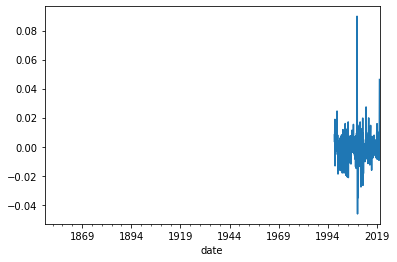

In [53]:
df['ILB_recent'].plot()

In [54]:
df.CPI1YR_F 

date
1850-01       NaN
1850-02       NaN
1850-03       NaN
1850-04       NaN
1850-05       NaN
            ...  
2019-11       NaN
2019-12    2.1384
2020-01       NaN
2020-02       NaN
2020-03    2.1582
Freq: M, Name: CPI1YR_F, Length: 2043, dtype: float64

In [50]:
df['ILB_older'] = 0.5*(df.CPI1YR_F + df.CPI10YR_F)
df['ILB_older'] = df.loc[df.ILB_older.first_valid_index():,'ILB_older'].fillna(method='ffill')
df['ILB_older'] = np.log(df.ILB_older/100+1) - np.log(df.ILB_older.shift(1)/100+1)

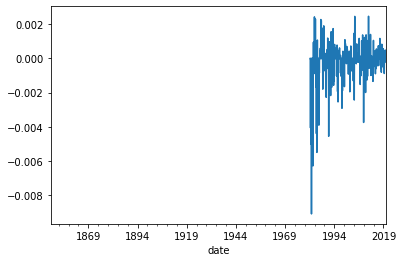

In [52]:
df['ILB_older'].plot()

In [51]:
# Centered moving average for timestamps (t-1, t, t+1).
df['ILB_oldest'] = df.loc[df.CPUSAM.first_valid_index():, 'CPUSAM'].fillna(method='ffill').rolling(window=3, center=True).mean()

In [82]:
df['ILB_oldest'] = df.loc[df.ILB_oldest.first_valid_index():, 'CPUSAM']
df['ILB_oldest'] = (
    np.log(df.ILB_oldest.shift(12) / df.ILB_oldest.shift(13)) +
    np.log(df.ILB_oldest / df.ILB_oldest.shift(1)) +
    np.log(df.ILB_oldest.shift(-12) / df.ILB_oldest.shift(-11))) / 3

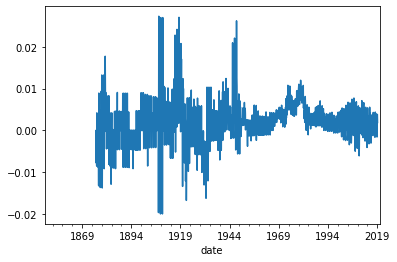

In [83]:
df.ILB_oldest.plot()

#### We assume a log return of centered moving averages of CPI (an index, not rate) is equivalent to a log return (reward) you can expect from bearing a surprise in inflation.

In [52]:
df['ILB_oldest'] = np.log(df.ILB_oldest/df.ILB_oldest.shift(1))

In [53]:
bf['ILB'] = df.ILB_recent.fillna(df.ILB_older)

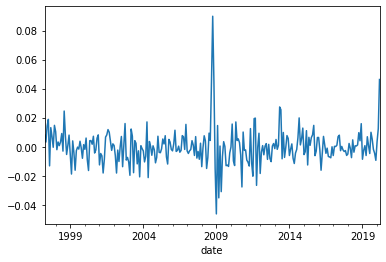

In [54]:
df['ILB_recent'].dropna().plot()

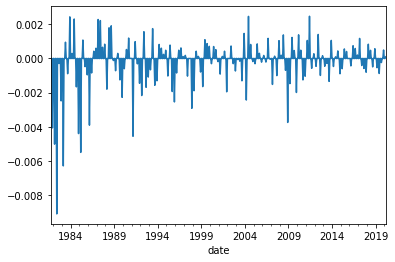

In [55]:
df.ILB_older.dropna().plot()

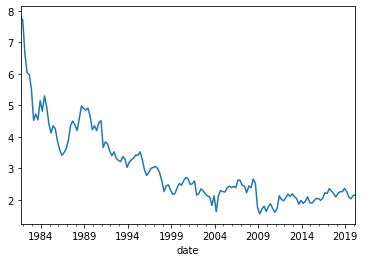

In [56]:
df.CPI1YR_F.dropna().plot()

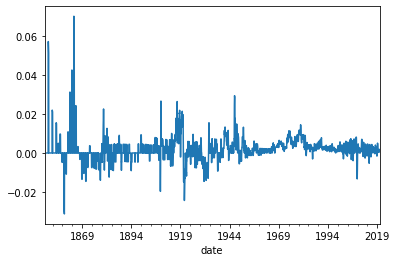

In [57]:
df.ILB_oldest.plot()

In [65]:
df.ILB_recent.dropna()

date
1997-04    0.008135
1997-05    0.003201
1997-06    0.014272
1997-07    0.018812
1997-08   -0.013217
             ...   
2019-11   -0.004536
2019-12   -0.009414
2020-01    0.003364
2020-02    0.012416
2020-03    0.046251
Freq: M, Name: ILB_recent, Length: 276, dtype: float64

In [61]:
df.ILB_oldest[df.ILB_recent.first_valid_index():]

date
1997-04    0.001042
1997-05    0.000624
1997-06    0.000624
1997-07    0.001455
1997-08    0.001867
             ...   
2019-11    0.000279
2019-12    0.000810
2020-01    0.001902
2020-02    0.001474
2020-03         NaN
Freq: M, Name: ILB_oldest, Length: 276, dtype: float64

In [84]:
comp = df.loc[df.ILB_recent.dropna().index, ['ILB_recent', 'ILB_older', 'ILB_oldest']]

In [85]:
comp
# bamboolib live code export
comp = comp.reset_index()
comp

,ILB_recent,ILB_older,ILB_oldest
date,,,
1997-04,0.008135,0.000000,0.002314
1997-05,0.003201,0.000000,0.001046
1997-06,0.014272,-0.001032,0.001038
1997-07,0.018812,0.000000,0.001462
1997-08,-0.013217,0.000000,0.001667
...,...,...,...
2019-11,-0.004536,0.000000,NaN
2019-12,-0.009414,0.000497,NaN
2020-01,0.003364,0.000000,NaN


  
  
5. `GOLD` (Gold): Log returns of gold prices.
  - **GOLD** : Gold (USD/ounce)
  
  
6. `INM` (Industrial Metals): Log returns of industrial metals index.
  - Since February 1977, **INM_idx**: S&P GSCI Industrial Metals.
  - Before that date, **CMWXMMM**: World Bank Metals and Minerals Commodity Price Index.
  
  
7. `ENGR` (Energy commodity)
  - Since February 1983, **ENGY_idx**: S&P GSCI Energy.
  - Before that date, an equally-weighted basket of **__WTC_D**: Crude Oil and **NG_P_WTD** Natural Gas.
  
  
8. `DXY` (U.S. Dollar)
  - Since February 1967, **DXY_idx**: U.S. Dollar Index
  - Before that date, an equally-weighted basket of G-10 currencies.
  
  
9. `FXCS` (Commodity vs. safe haven currencies)
  - Since January 1987, an equally-weighted basket of USDCAD, USDNOK and AUDUSD vs USDCHF and USDJPY.
  - Since January 1980, USDJPY is excluded from what's above.
  - Before that date, USDNOK is further excluded from what's above.

In [40]:
df_bbg.TIPS_idx - df_bbg.GLT_idx

date
1959-12          NaN
1960-01          NaN
1960-02          NaN
1960-03          NaN
1960-04          NaN
             ...    
2019-11   -2066.9561
2019-12   -2052.3773
2020-01   -2103.6229
2020-02   -2163.4876
2020-03   -2241.3439
Freq: M, Length: 724, dtype: float64

In [41]:
df
# bamboolib live code export
df = df.reset_index()
df

,Date,CMWXMMM,CPUSAM,GBPUSD_rate,IDUSAD,ITUSA3CMD,NG_P_WTD,TRUSACOM,TRUSG10M,USDBEF_rate,...,EMEQ_idx,ACEQ_idx,DMEQ_recent,DMEQ_older,GLT_recent,GLT_older,CRE_recent,CRE_older,ILB_recent,ILB_older
0,1850-01,NaN,NaN,23.047528,NaN,NaN,NaN,1.051075,3.306525,5.2607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1850-02,NaN,NaN,23.428364,NaN,NaN,NaN,1.055901,3.315689,5.2468,...,NaN,NaN,NaN,NaN,NaN,0.002768,NaN,NaN,NaN,NaN
2,1850-03,NaN,NaN,23.360561,NaN,NaN,NaN,1.052282,3.273533,5.2524,...,NaN,NaN,NaN,NaN,NaN,-0.012796,NaN,NaN,NaN,NaN
3,1850-04,NaN,NaN,23.091783,NaN,NaN,NaN,1.057999,3.475150,5.2775,...,NaN,NaN,NaN,NaN,NaN,0.059768,NaN,NaN,NaN,NaN
4,1850-05,NaN,NaN,23.911980,NaN,NaN,NaN,1.081762,3.482482,5.2330,...,NaN,NaN,NaN,NaN,NaN,0.002107,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,2019-11,76.215305,257.208,1.672875,NaN,1.59,NaN,24038.670000,10953.936305,0.9079,...,1040.05,546.70,0.025955,0.033480,-0.003012,-0.002955,0.004164,-0.004744,0.004536,-0.004744
2039,2019-12,77.469997,256.974,1.759655,NaN,1.55,NaN,23920.300000,10836.125049,0.8917,...,1114.66,565.24,0.028475,0.028189,-0.005630,-0.010813,0.007146,0.003983,0.009414,0.003983
2040,2020-01,77.702232,257.971,1.742672,NaN,1.55,NaN,24418.540000,11252.031439,0.9013,...,1062.34,558.62,-0.006833,-0.001629,0.024143,0.037663,0.006421,0.000854,-0.003364,0.000854
2041,2020-02,73.015869,258.678,1.643800,NaN,1.27,NaN,24727.670000,11666.405078,0.9069,...,1005.52,512.76,-0.089851,-0.087860,0.026161,0.036165,-0.007678,-0.004438,-0.012416,-0.004438
